In [1]:
import json
import os
import re
import glob
import copy
from datetime import datetime

with open('../activities_map.json') as f:
    activities_map = json.load(f)


def is_match_in_activity_list(activity_list, activity):
    for activity_name in activity_list:
        if activity_name.endswith(activity):
            return True

    return False

def get_activity_coverage(app_name, droidbot_result_path):
    states_in_utg = set()
    assert os.path.exists(droidbot_result_path), f'{droidbot_result_path} does not exist'
    
    if os.path.exists(os.path.join(droidbot_result_path, 'utg.js')):
        with open(os.path.join(droidbot_result_path, 'utg.js')) as f:
            content = f.readlines()
        states_in_utg = set()
        for line in content:
            line = line.strip()
            if line.startswith('"image":'):
                state_tag = line.split('states/screen_')[-1].split('.png')[0]
                states_in_utg.add(f'state_{state_tag}.json')

    state_files = sorted(glob.glob(os.path.join(droidbot_result_path, 'states', '*.json')))

    if len(states_in_utg) > 0:
        state_files = [state_file for state_file in state_files if os.path.basename(state_file) in states_in_utg]

    covered_activities_so_far = set()
    timeline = []
    start_time = None
    for state_file in state_files:
        with open(state_file) as f:
            state = json.load(f)
        foreground_activity = state['foreground_activity']
        if foreground_activity.endswith('}'):
            foreground_activity = foreground_activity[:-1]
        foreground_activity = foreground_activity.split('/')[-1]
        if is_match_in_activity_list(activities_map[app_name], foreground_activity):
            covered_activities_so_far.add(foreground_activity)

        timestamp = os.path.basename(state_file).removeprefix('state_').removesuffix('.json')
        timestamp = datetime.strptime(timestamp, '%Y-%m-%d_%H%M%S')

        if start_time is None:
            start_time = timestamp

        time_offset = (timestamp - start_time).total_seconds()
        if time_offset > 7200:
            break

        timeline.append((timestamp, len(covered_activities_so_far)))

    return timeline, len(activities_map[app_name])


def get_droidagent_data(droidagent_result_path):
    with open(os.path.join(droidagent_result_path, 'exp_data.json')) as f:
        data = json.load(f)
    return data['visited_activities'], data['app_activities']


In [2]:
rows = []

for project in os.listdir('../data/'):
    if project == "QuickChat":
        continue
    if project == '.keep':
        continue
    if project == '.DS_Store':
        continue

    result_path = os.path.join('../data/', project)
    timeline_droidagent, num_all_activities = get_activity_coverage(project, result_path)
    
    # gptdroid = actor-only version of droidagent
    gptdroid_result_path = glob.glob(f'../baselines/gptdroid/{project}')
    timeline_actoronly, _ = get_activity_coverage(project, gptdroid_result_path[0])

    noknowledge_baseline_result_path = glob.glob(f'../ablation/ablation_noknowledge_baseline_noknowledge_output_coverage/{project}')
    if len(noknowledge_baseline_result_path) == 0:
        continue
    noknowledge_baseline_result_path = noknowledge_baseline_result_path[0]
    timeline_noknowledge, _ = get_activity_coverage(project, noknowledge_baseline_result_path)
    if len(noknowledge_baseline_result_path) == 0:
        continue

    # infer droidagent_nocritique result path
    nocritique_baseline_result_path = glob.glob(f'../ablation/ablation_nocritique_baseline_nocritique_output_coverage/{project}')
    if len(nocritique_baseline_result_path) == 0:
        continue
    nocritique_baseline_result_path = nocritique_baseline_result_path[0]
    timeline_nocritique, _ = get_activity_coverage(project, nocritique_baseline_result_path)
    
    print(project)
    rows.append({
        'App Name': project,
        'coverage': timeline_droidagent[-1][1]/num_all_activities,
        'covered_num': timeline_droidagent[-1][1],
        'technique': 'DroidAgent',
        'total': num_all_activities,
    })
    rows.append({
        'App Name': project,
        'coverage': timeline_noknowledge[-1][1]/num_all_activities,
        'covered_num': timeline_noknowledge[-1][1],
        'technique': 'NoKnowledge',
        'total': num_all_activities,
    })
    rows.append({
        'App Name': project,
        'coverage': timeline_nocritique[-1][1]/num_all_activities,
        'covered_num': timeline_nocritique[-1][1],
        'technique': 'NoKnowledgeAndCritique',
        'total': num_all_activities,
    })
    rows.append({
        'App Name': project,
        'coverage': timeline_actoronly[-1][1]/num_all_activities,
        'covered_num': timeline_actoronly[-1][1],
        'technique': 'Actor-only',
        'total': num_all_activities,
    })
    rows.append({
        'App Name': project,
        'coverage': 1,
        'covered_num': num_all_activities,
        'technique': 'total',
        'total': num_all_activities,
    })

import pandas as pd
df = pd.DataFrame(rows)
df


Phonograph
collect
commons
AnkiDroid
ActivityDiary


,App Name,coverage,covered_num,technique,total
0,Phonograph,0.916667,11,DroidAgent,12
1,Phonograph,0.916667,11,NoKnowledge,12
2,Phonograph,0.750000,9,NoKnowledgeAndCritique,12
3,Phonograph,0.500000,6,Actor-only,12
4,Phonograph,1.000000,12,total,12
5,collect,0.351351,13,DroidAgent,37
6,collect,0.243243,9,NoKnowledge,37
7,collect,0.243243,9,NoKnowledgeAndCritique,37
8,collect,0.054054,2,Actor-only,37
9,collect,1.000000,37,total,37


In [3]:
df['covered'] = df.apply(lambda row: f'{row.covered_num} ({round(row.coverage, 2)})', axis=1)
df.pivot(index='App Name', columns='technique', values='covered').round(2)

technique,Actor-only,DroidAgent,NoKnowledge,NoKnowledgeAndCritique,total
App Name,,,,,
ActivityDiary,6 (0.6),10 (1.0),9 (0.9),9 (0.9),10 (1.0)
AnkiDroid,6 (0.27),15 (0.68),13 (0.59),12 (0.55),22 (1.0)
Phonograph,6 (0.5),11 (0.92),11 (0.92),9 (0.75),12 (1.0)
collect,2 (0.05),13 (0.35),9 (0.24),9 (0.24),37 (1.0)
commons,7 (0.41),14 (0.82),13 (0.76),13 (0.76),17 (1.0)


/var/folders/nn/kfc9twsx3kq0b3xmpb25k5w40000gn/T/ipykernel_12955/821051348.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="technique", y="coverage", data=df, palette='Set2', errorbar='sd')
/var/folders/nn/kfc9twsx3kq0b3xmpb25k5w40000gn/T/ipykernel_12955/821051348.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=60, fontsize=12)


[Text(0, 0, 'DroidAgent'),
 Text(1, 0, 'NoKnowledge'),
 Text(2, 0, 'NoKnowledgeAndCritique'),
 Text(3, 0, 'Actor-only')]

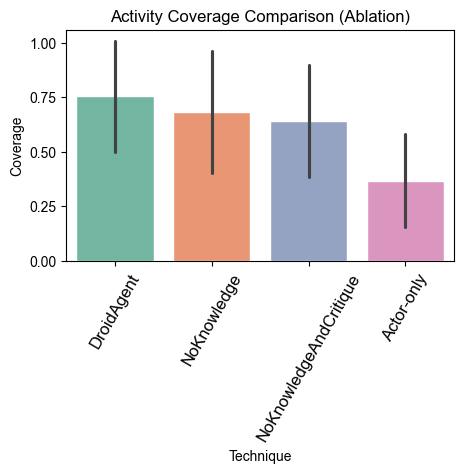

In [4]:
# aggregated
import seaborn as sns
import matplotlib.pyplot as plt 

df = df[df['technique'] != 'total']

plt.figure(figsize=(5, 3))
plt.title('Activity Coverage Comparison (Ablation)')
# font size 
sns.set(font_scale=1.5)
sns.set_style('whitegrid')
ax = sns.barplot(x="technique", y="coverage", data=df, palette='Set2', errorbar='sd')
ax.set(xlabel='Technique', ylabel='Coverage')
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, fontsize=12)


/var/folders/nn/kfc9twsx3kq0b3xmpb25k5w40000gn/T/ipykernel_12955/3546021090.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=13)


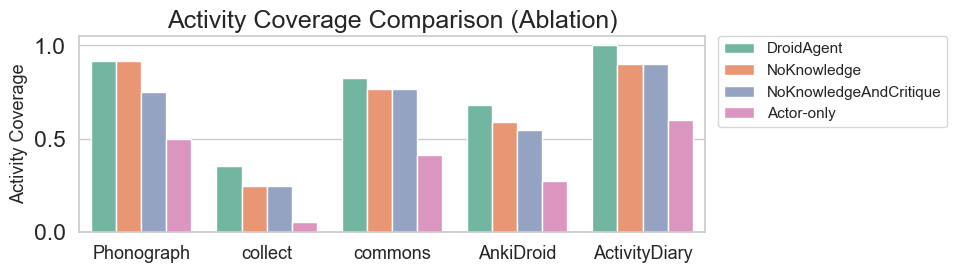

In [5]:
# subfigure for each application
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df = df[df['technique'] != 'total']

plt.figure(figsize=(10, 3))
plt.title('Activity Coverage Comparison (Ablation)')
# font size
sns.set(font_scale=1.3)
sns.set_style('whitegrid')
ax = sns.barplot(x="App Name", y="coverage", hue="technique", data=df, palette='Set2')
ax.set(xlabel='', ylabel='Activity Coverage')
ax.set_ylabel('Activity Coverage', fontsize=13)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=13)
# legend outside
ax.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0., fontsize=11)
plt.tight_layout()
plt.savefig('./RQ3_ablation.pdf', dpi=300)

/var/folders/nn/kfc9twsx3kq0b3xmpb25k5w40000gn/T/ipykernel_12955/2786765967.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="technique", y="coverage", data=df, palette='Set2', errorbar='sd')
/var/folders/nn/kfc9twsx3kq0b3xmpb25k5w40000gn/T/ipykernel_12955/2786765967.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=80)


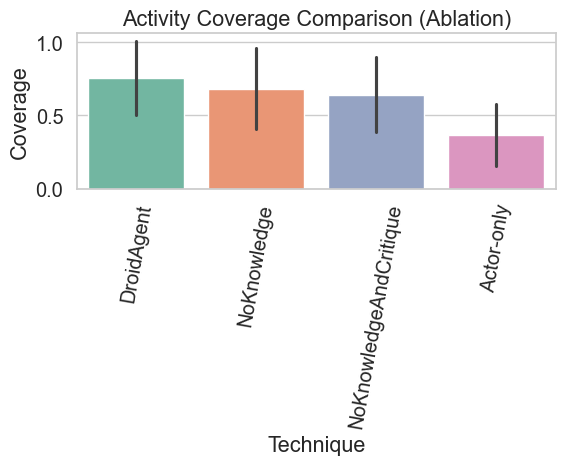

In [6]:
# aggregated
import seaborn as sns
import matplotlib.pyplot as plt 

df = df[df['technique'] != 'total']

plt.figure(figsize=(6, 5))
plt.title('Activity Coverage Comparison (Ablation)')
# font size 
sns.set(font_scale=1.5)
sns.set_style('whitegrid')
ax = sns.barplot(x="technique", y="coverage", data=df, palette='Set2', errorbar='sd')
ax.set(xlabel='Technique', ylabel='Coverage')
ax.set_xticklabels(ax.get_xticklabels(), rotation=80)
plt.tight_layout()
plt.savefig('./RQ3_ablation_agg.pdf', dpi=300)